In [2]:
import os
import pandas as pd 
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import scipy.stats as stats
import platform

if platform.system() == 'Darwin':
    plt.rc('font', family = 'AppleGothic')
else:
    plt.rc('font', family = 'Malgun Gothic')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#### 비상장 외감기업과 상장기업 불러오기
# 1. 외감
data1 = pd.read_csv('외감(GAAP).csv')
data1 = data1[data1['회계년도'].str.endswith('/12')]
year_list1 = data1['회계년도'].unique()
company_list1 = data1['회사명'].unique()

# 2. IFRS
data2 = pd.read_csv('상장(IFRS).csv')
data2 = data2[data2['회계년도'].str.endswith('/12')]
year_list2 = data2['회계년도'].unique()
company_list2 = data2['회사명'].unique()

default_date = datetime.strptime('2011-12-01', '%Y-%m-%d')

In [ ]:
#### 자산 총계와 부채 총계를 계산하기 앞서 결측값들을 날린다
# 1. 외감
data1 = data1.dropna(subset=['자산총계(요약)(백만원)', '부채총계(요약)(백만원)'])
data1.index = pd.to_datetime(data1['회계년도'])

# 2. 상장
data2 = data2.dropna(subset=['자산(*)(요약)(IFRS연결)(백만원)', '부채(*)(요약)(IFRS연결)(백만원)'])
data2.index = pd.to_datetime(data2['회계년도'])

In [ ]:
position = 'GAAP'   # GAAP : 비상장 외감기업, IFRS : 상장 기업
if position == 'GAAP':
    
    dataframe1 = pd.DataFrame()

    for i, company in enumerate(company_list1):

        tem = data1[data1['회사명'] == company]
        tem.sort_index(inplace=True)
        
        tem_index_diff = tem.index.to_series().diff(1)
        tem_index_diff.apply(lambda x: 1 if x >= timedelta(days=400) else 0)

        asset = []
        debt = []
        for j in range(len(tem)):
            
            if j == 0:
                asset.append(tem['자산총계(요약)(백만원)'][j])
                debt.append(tem['부채총계(요약)(백만원)'][j])

            elif (tem_index_diff[j] == 1):
                asset.append(tem['자산총계(요약)(백만원)'][j])
                debt.append(tem['부채총계(요약)(백만원)'][j])
            
            else:

                if (tem['자산총계(요약)(백만원)'][j] == 0):
                    asset.append(0)

                elif (tem['자산총계(요약)(백만원)'][j-1] == 0):
                    asset.append(tem['자산총계(요약)(백만원)'][j])

                else:
                    asset.append((tem['자산총계(요약)(백만원)'][j] + tem['자산총계(요약)(백만원)'][j-1])/2)


                if (tem['부채총계(요약)(백만원)'][j] == 0):
                    debt.append(0)

                elif (tem['부채총계(요약)(백만원)'][j-1] == 0):
                    debt.append(tem['부채총계(요약)(백만원)'][j])

                else:
                    debt.append((tem['부채총계(요약)(백만원)'][j] + tem['부채총계(요약)(백만원)'][j-1])/2)

        tem['자산총계'] = asset
        tem['부채총계'] = debt

        if dataframe1.empty != True:
            dataframe1 = pd.concat([dataframe1, tem], axis=0)
        else:
            dataframe1 = tem
        
        print(f'{i}번째 읽어옴')

elif position == 'IFRS':

    dataframe2 = pd.DataFrame()

    for i, company in enumerate(company_list2):

        tem = data2[data2['회사명'] == company]
        tem.sort_index(inplace=True)
        
        tem_index_diff = tem.index.to_series().diff(1)
        tem_index_diff.apply(lambda x: 1 if x >= timedelta(days=400) else 0)

        asset = []
        debt = []
        for j in range(len(tem)):

            
            if tem.index[j] == datetime.strptime('2010-12-01', '%Y-%m-%d') :
                asset.append(0)
                debt.append(0)

            elif (  (tem.index[j] == datetime.strptime('2011-12-01', '%Y-%m-%d')) | 
                  ((j == 0) & (tem.index[j] != datetime.strptime('2010-12-01', '%Y-%m-%d')) ) ):
                asset.append(tem['자산(*)(요약)(IFRS연결)(백만원)'][j])
                debt.append(tem['부채(*)(요약)(IFRS연결)(백만원)'][j])
  
            elif (tem_index_diff[j] == 1):
                asset.append(tem['자산(*)(요약)(IFRS연결)(백만원)'][j])
                debt.append(tem['부채(*)(요약)(IFRS연결)(백만원)'][j])
            
            else:

                if (tem['자산(*)(요약)(IFRS연결)(백만원)'][j] == 0):
                    asset.append(0)

                elif (tem['자산(*)(요약)(IFRS연결)(백만원)'][j-1] == 0):
                    asset.append(tem['자산(*)(요약)(IFRS연결)(백만원)'][j])

                else:
                    asset.append((tem['자산(*)(요약)(IFRS연결)(백만원)'][j] + tem['자산(*)(요약)(IFRS연결)(백만원)'][j-1])/2)


                if (tem['부채(*)(요약)(IFRS연결)(백만원)'][j] == 0):
                    debt.append(0)

                elif (tem['부채(*)(요약)(IFRS연결)(백만원)'][j-1] == 0):
                    debt.append(tem['부채(*)(요약)(IFRS연결)(백만원)'][j])

                else:
                    debt.append((tem['부채(*)(요약)(IFRS연결)(백만원)'][j] + tem['부채(*)(요약)(IFRS연결)(백만원)'][j-1])/2)

        tem['자산총계'] = asset
        tem['부채총계'] = debt

        if dataframe2.empty != True:
            dataframe2 = pd.concat([dataframe2, tem], axis=0)
        else:
            dataframe2 = tem
        
        print(f'{i}번째 읽어옴')
else:
    pass

In [ ]:
dataframe1 = dataframe1.drop(['자산총계(요약)(백만원)', '부채총계(요약)(백만원)'], axis=1)
dataframe2 = dataframe2.drop(['자산(*)(요약)(IFRS연결)(백만원)', '부채(*)(요약)(IFRS연결)(백만원)'], axis=1)

In [ ]:
# 1. 외감
# dataframe1.to_csv('외감GAAP 가공된거.csv', encoding='utf-8 sig')

# 2. 상장
# dataframe2.to_csv('상장IFRS 가공된거.csv', encoding='utf-8 sig')

### 후보피쳐 만들기

In [ ]:
data = pd.read_csv('30개피쳐만들기 직전최종합.csv')     # 자산총계, 부채총계 만들고 비상장외감기업과 상장기업 데이터를 뭉쳐놓은 후 결측치 제거한 파일

In [ ]:
data.isna().sum().sum()     # 결측치 확인

In [ ]:
my_columns_list = ['회사명', '거래소코드', '회계년도', '총자산경상이익률', '총자산순이익률', '금융비용/매출액', '금융비용/총부채', '순금융비용/매출액', '매출액경상이익률', '매출액순이익률', '자기자본경상이익률', '자기자본순이익률',
                   'EBITDA/이자비용', 'EBIT/이자비용', '영업현금흐름/이자비용', '잉여현금흐름/총자산', '잉여현금흐름/총부채', '잉여현금흐름/이자비용', '부채상환계수',
                   '자기자본비율', '유동자산/총자산', '이익잉여금/총자산', '이익잉여금/총부채', '이익잉여금/유동자산', '현금비율', '당좌비율', '유동비율',
                   '유동부채회전율', '총자산', '매출액', '고정자산']    # 회사명, 거래소코드, 회계년도 그리고 후보피쳐 리스트

In [ ]:
df = pd.DataFrame(columns=my_columns_list)
df['회사명'] = data['회사명']
df['거래소코드'] = data['거래소코드']
df['회계년도'] = data['회계년도']

1. 분모가 0인것들이 이미 날려져서 신경 안써도 되는 경우
 - 잉여현금흐름/총자산
 - 잉여현금흐름/총부채
 - 유동자산/총자산
 - 이익잉여금/총부채
 - 금융비용/총부채
 - 순금융비용/매출액
 - 이익잉여금/총자산

2. 분모가 0인 경우 MAX 처리
 - EBIT/이자비용
 - EBITDA/이자비용
 - 영업현금흐름/이자비용
 - 잉여현금흐름/이자비용
 - 유동부채회전율

In [ ]:
### EBITDA/이자비용
df['EBITDA/이자비용'] = np.where(data['이자비용(요약)(백만원)'] != 0, 
                             ((data['영업이익(요약)(백만원)']+(data['[제조]   감가상각비']/1000)) / (data['이자비용(요약)(백만원)'])), 0)
max_value1 = df['EBITDA/이자비용'].max()
df['EBITDA/이자비용'] = np.where(data['이자비용(요약)(백만원)'] == 0, max_value1, df['EBITDA/이자비용'])

### EBIT/이자비용
df['EBIT/이자비용'] = np.where(data['이자비용(요약)(백만원)'] != 0, 
                           ((data['영업이익(요약)(백만원)']+data['기타영업외수익(요약)(백만원)']-data['기타영업외비용(요약)(백만원)']) / (data['이자비용(요약)(백만원)'])), 0)
max_value2 = df['EBIT/이자비용'].max()
df['EBIT/이자비용'] = np.where(data['이자비용(요약)(백만원)'] == 0, max_value2, df['EBIT/이자비용'])

### 영업현금흐름/이자비용
df['영업현금흐름/이자비용'] = np.where(data['이자비용(요약)(백만원)'] != 0, 
                             ((data['영업활동으로 인한 현금흐름(요약)(백만원)']) / (data['이자비용(요약)(백만원)'])), 0)
max_value3 = df['영업현금흐름/이자비용'].max()
df['영업현금흐름/이자비용'] = np.where(data['이자비용(요약)(백만원)'] == 0, max_value3, df['영업현금흐름/이자비용'])

### 잉여현금흐름/이자비용
df['잉여현금흐름/이자비용'] = np.where(data['이자비용(요약)(백만원)'] != 0, 
                             ((data['영업활동으로 인한 현금흐름(요약)(백만원)'] - data['투자활동으로 인한 현금흐름(요약)(백만원)']) / (data['이자비용(요약)(백만원)'])), 0)
max_value4 = df['잉여현금흐름/이자비용'].max()
df['잉여현금흐름/이자비용'] = np.where(data['이자비용(요약)(백만원)'] == 0, max_value4, df['잉여현금흐름/이자비용'])

### 유동부채회전율
df['유동부채회전율'] = np.where(data['유동부채(요약)(백만원)'] != 0, 
                             (data['매출액(요약)(백만원)'] / data['유동부채(요약)(백만원)']), 0)
max_value5 = df['유동부채회전율'].max()
df['유동부채회전율'] = np.where(data['유동부채(요약)(백만원)'] == 0, max_value5, df['유동부채회전율'])

3. 분모가 0인 경우 MIN 처리
 - 이익잉여금/유동자산

In [ ]:
### 이익잉여금/유동자산
df['이익잉여금/유동자산'] = np.where(data['유동자산(요약)(백만원)'] != 0, 
                             ((data['이익잉여금(요약)(백만원)']) / (data['유동자산(요약)(백만원)'])), 0)
min_value1 = df['이익잉여금/유동자산'].min()
df['이익잉여금/유동자산'] = np.where(data['이자비용(요약)(백만원)'] == 0, min_value1, df['이익잉여금/유동자산'])

4. 분모의 구성항목 모두 0인 경우 MAX 처리
 - 부채상환계수

In [ ]:
### 부채상환계수
df['부채상환계수'] = np.where( ((data['이자비용(요약)(백만원)'] != 0) | (data['단기차입금(요약)(백만원)'] != 0) | (data['유동성장기부채(요약)(백만원)'] != 0)), 
                    ((data['영업이익(요약)(백만원)']+(data['[제조]   감가상각비']/1000)) / (data['이자비용(요약)(백만원)']+data['단기차입금(요약)(백만원)']+data['유동성장기부채(요약)(백만원)'])), 0)
max_value6 = df['부채상환계수'].max()
df['부채상환계수'] = np.where(((data['이자비용(요약)(백만원)'] == 0) & (data['단기차입금(요약)(백만원)'] == 0) & (data['유동성장기부채(요약)(백만원)'] == 0)), max_value6, df['부채상환계수'])

5. 값이 0인 경우 '유동부채(요약)(백만원)'가 0인 경우 MAX, 아닌 경우 0으로 처리
- 현금비율
- 당좌비율
- 유동비율

In [ ]:
### 현금비율
df['현금비율'] = np.where(data['현금비율'] != 0, data['현금비율'], 0)
max_value7 = df['현금비율'].max()
df['현금비율'] = np.where( ((data['현금비율'] == 0) & (data['유동부채(요약)(백만원)'] == 0)), max_value7, df['현금비율'])
df['현금비율'] = np.where( ((data['현금비율'] == 0) & (data['유동부채(요약)(백만원)'] != 0)), 0, df['현금비율'])

### 당좌비율
df['당좌비율'] = np.where(data['당좌비율'] != 0, data['당좌비율'], 0)
max_value8 = df['현금비율'].max()
df['당좌비율'] = np.where( ((data['당좌비율'] == 0) & (data['유동부채(요약)(백만원)'] == 0)), max_value8, df['당좌비율'])
df['당좌비율'] = np.where( ((data['당좌비율'] == 0) & (data['유동부채(요약)(백만원)'] != 0)), 0, df['당좌비율'])

### 유동비율
df['유동비율'] = np.where(data['유동비율'] != 0, data['유동비율'], 0)
max_value9 = df['유동비율'].max()
df['유동비율'] = np.where( ((data['유동비율'] == 0) & (data['유동부채(요약)(백만원)'] == 0)), max_value9, df['유동비율'])
df['유동비율'] = np.where( ((data['유동비율'] == 0) & (data['유동부채(요약)(백만원)'] != 0)), 0, df['유동비율'])

In [ ]:
df['총자산경상이익률']= data['총자본영업이익률']
df['총자산순이익률'] = data['총자본순이익률']
df['금융비용/매출액'] = data['금융비용부담률']/100
df['금융비용/총부채'] = (df['금융비용/매출액']*data['매출액(요약)(백만원)']) /data['부채총계(요약)(백만원)']
df['순금융비용/매출액'] = (data['이자비용(요약)(백만원)']-data['이자수익(요약)(백만원)']) / data['매출액(요약)(백만원)']
df['매출액경상이익률'] = data['매출액영업이익률']
df['매출액순이익률'] = data['매출액순이익률']
df['자기자본경상이익률'] = data['자기자본영업이익률']
df['자기자본순이익률'] = data['자기자본순이익률']


df['잉여현금흐름/총자산'] = (data['영업활동으로 인한 현금흐름(요약)(백만원)'] - data['투자활동으로 인한 현금흐름(요약)(백만원)']) / (data['자산총계(요약)(백만원)'])
df['잉여현금흐름/총부채'] = (data['영업활동으로 인한 현금흐름(요약)(백만원)'] - data['투자활동으로 인한 현금흐름(요약)(백만원)']) / (data['부채총계(요약)(백만원)'])


df['자기자본비율'] = data['자기자본구성비율']
df['유동자산/총자산'] = (data['유동자산(요약)(백만원)']) / (data['자산총계(요약)(백만원)'])
df['이익잉여금/총자산'] = (data['이익잉여금(요약)(백만원)']) / (data['자산총계(요약)(백만원)'])
df['이익잉여금/총부채'] = (data['이익잉여금(요약)(백만원)']) / (data['부채총계(요약)(백만원)'])
 
df['총자산'] = data['자산총계(요약)(백만원)']*1000000
df['매출액'] = data['매출액(요약)(백만원)']*1000000
df['고정자산'] = data['비유동자산(요약)(백만원)']*1000000

# df['재고자산회전율'] = data['재고자산회전률']
# df['매출채권회전율'] = data['매출채권회전률']

In [ ]:
np.isinf(df.drop(['회사명', '거래소코드', '회계년도'], axis=1)).any()   # 무한대 값이 있는지 확인

In [ ]:
np.isneginf(df.drop(['회사명', '거래소코드', '회계년도'], axis=1)).any()    # 음의 무한대 값이 있는지 확인

In [ ]:
df.to_csv('최종.csv', encoding='utf-8 sig')

#### train과 test로 나눈 후 train에대해 이상치 제거

In [3]:
df = pd.read_csv('최종_동태.csv', index_col=0)
df['회계년도'] = pd.to_datetime(df['회계년도'])

In [4]:
df_test = df[df['회계년도'] >= datetime.strptime('2021-12-01', '%Y-%m-%d')]
df_train = df[df['회계년도'] < datetime.strptime('2021-12-01', '%Y-%m-%d')]

In [5]:
from scipy import stats

def qqplot(df,ncols,nrows):
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams["font.family"] = "Malgun Gothic"
   
    fig, axs = plt.subplots(nrows, ncols, constrained_layout=True)
    fig.set_size_inches((70, 60))

    for ax, i in zip(axs.ravel(), df):
            stats.probplot(df[i], dist=stats.norm, plot=ax)
            ax.set_title(str(i))

    plt.show()

In [6]:
temp_df = df_train.drop(['거래소코드', '회계년도', '부실여부'], axis=1)
my_col = list(temp_df.columns)
my_droped = ['거래소코드', '회계년도', '부실여부']

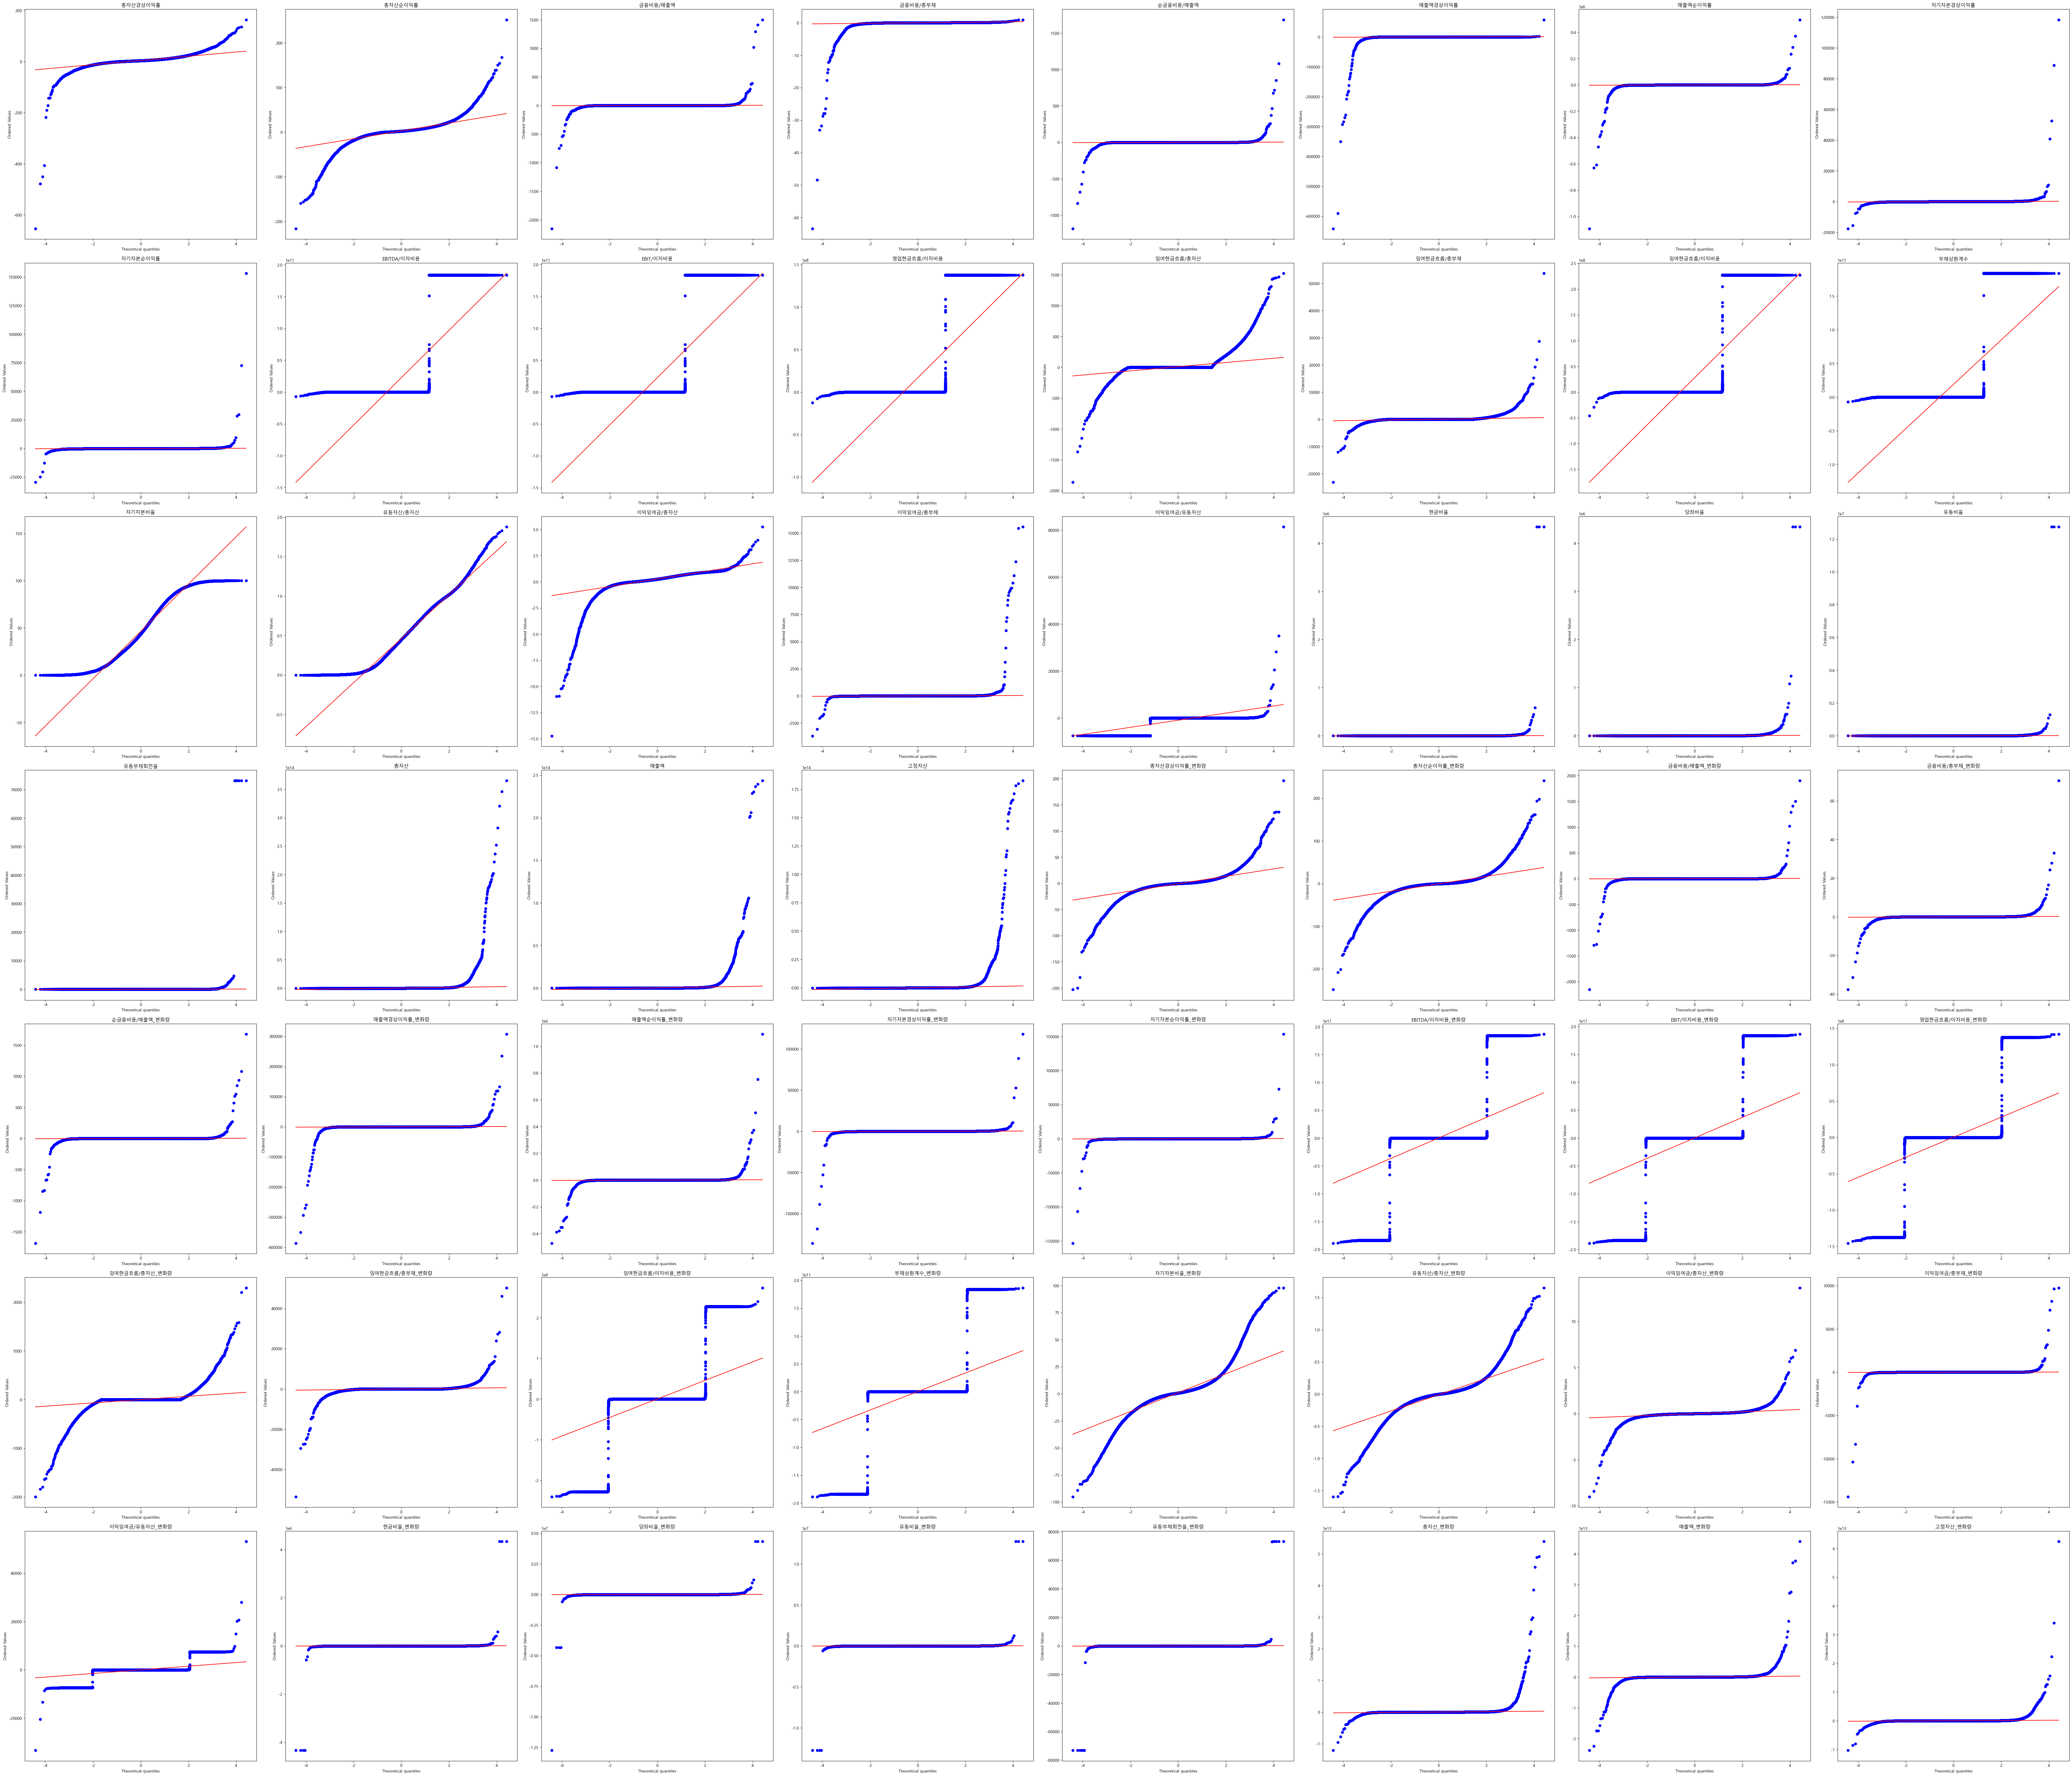

In [7]:
qqplot(temp_df,8,7)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## histogram
col_n = 8
row_n = 7

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(30,row_n*5))

for i,col in enumerate(my_col):
    sns.distplot(temp_df[col], bins=20, ax=ax[int(i/col_n),int(i%col_n)])

In [ ]:
df_winsorized = temp_df.copy()

In [ ]:
from scipy.stats.mstats import winsorize

df_winsorized[my_col[0]] = winsorize(df_winsorized[my_col[0]], limits= (0.0075,0.0025))
df_winsorized[my_col[1]] = winsorize(df_winsorized[my_col[1]], limits= (0.005, 0.005))
df_winsorized[my_col[2]] = winsorize(df_winsorized[my_col[2]], limits= (0.005, 0.005))
df_winsorized[my_col[3]] = winsorize(df_winsorized[my_col[3]], limits= (0.0075, 0.0025))
df_winsorized[my_col[4]] = winsorize(df_winsorized[my_col[4]], limits= (0.005, 0.005))
df_winsorized[my_col[5]] = winsorize(df_winsorized[my_col[5]], limits= (0.0075, 0.0025))
df_winsorized[my_col[6]] = winsorize(df_winsorized[my_col[6]], limits= (0.005, 0.005))
df_winsorized[my_col[7]] = winsorize(df_winsorized[my_col[7]], limits= (0.005, 0.005))

df_winsorized[my_col[8]] = winsorize(df_winsorized[my_col[8]], limits= (0.005, 0.005))
# df_winsorized[my_col[9]] = winsorize(df_winsorized[my_col[9]], limits= (0, 0.01))
# df_winsorized[my_col[10]] = winsorize(df_winsorized[my_col[10]], limits= (0, 0.01))
# df_winsorized[my_col[11]] = winsorize(df_winsorized[my_col[11]], limits= (0, 0.01))
df_winsorized[my_col[12]] = winsorize(df_winsorized[my_col[12]], limits= (0.005, 0.005))
df_winsorized[my_col[13]] = winsorize(df_winsorized[my_col[13]], limits= (0.005, 0.005))
df_winsorized[my_col[14]] = winsorize(df_winsorized[my_col[14]], limits= (0.01, 0))
# df_winsorized[my_col[15]] = winsorize(df_winsorized[my_col[15]], limits= (0, 0.01))

df_winsorized[my_col[16]] = winsorize(df_winsorized[my_col[16]], limits= (0, 0.01))
df_winsorized[my_col[17]] = winsorize(df_winsorized[my_col[17]], limits= (0, 0.01))
df_winsorized[my_col[18]] = winsorize(df_winsorized[my_col[18]], limits= (0.0075, 0.0025))
df_winsorized[my_col[19]] = winsorize(df_winsorized[my_col[19]], limits= (0.005, 0.005))
df_winsorized[my_col[20]] = winsorize(df_winsorized[my_col[20]], limits= (0, 0.01))
df_winsorized[my_col[21]] = winsorize(df_winsorized[my_col[21]], limits= (0, 0.01))
df_winsorized[my_col[22]] = winsorize(df_winsorized[my_col[22]], limits= (0, 0.01))
df_winsorized[my_col[23]] = winsorize(df_winsorized[my_col[23]], limits= (0, 0.01))

df_winsorized[my_col[24]] = winsorize(df_winsorized[my_col[24]], limits= (0, 0.01))
df_winsorized[my_col[25]] = winsorize(df_winsorized[my_col[25]], limits= (0, 0.01))
df_winsorized[my_col[26]] = winsorize(df_winsorized[my_col[26]], limits= (0, 0.01))
df_winsorized[my_col[27]] = winsorize(df_winsorized[my_col[27]], limits= (0, 0.01))
df_winsorized[my_col[28]] = winsorize(df_winsorized[my_col[28]], limits= (0.005, 0.005))
df_winsorized[my_col[29]] = winsorize(df_winsorized[my_col[29]], limits= (0.005, 0.005))
df_winsorized[my_col[30]] = winsorize(df_winsorized[my_col[30]], limits= (0.005, 0.005))
df_winsorized[my_col[31]] = winsorize(df_winsorized[my_col[31]], limits= (0.005, 0.005))

df_winsorized[my_col[32]] = winsorize(df_winsorized[my_col[32]], limits= (0.005, 0.005))
df_winsorized[my_col[33]] = winsorize(df_winsorized[my_col[33]], limits= (0.005, 0.005))
df_winsorized[my_col[34]] = winsorize(df_winsorized[my_col[34]], limits= (0.005, 0.005))
df_winsorized[my_col[35]] = winsorize(df_winsorized[my_col[35]], limits= (0.005, 0.005))
df_winsorized[my_col[36]] = winsorize(df_winsorized[my_col[36]], limits= (0.005, 0.005))
# df_winsorized[my_col[37]] = winsorize(df_winsorized[my_col[37]], limits= (0, 0.01))
# df_winsorized[my_col[38]] = winsorize(df_winsorized[my_col[38]], limits= (0, 0.01))
# df_winsorized[my_col[39]] = winsorize(df_winsorized[my_col[39]], limits= (0, 0.01))

df_winsorized[my_col[40]] = winsorize(df_winsorized[my_col[40]], limits= (0.005, 0.005))
df_winsorized[my_col[41]] = winsorize(df_winsorized[my_col[41]], limits= (0.005, 0.005))
df_winsorized[my_col[42]] = winsorize(df_winsorized[my_col[42]], limits= (0.005, 0.005))
df_winsorized[my_col[43]] = winsorize(df_winsorized[my_col[43]], limits= (0, 0.01))
df_winsorized[my_col[44]] = winsorize(df_winsorized[my_col[44]], limits= (0.005, 0.005))
df_winsorized[my_col[45]] = winsorize(df_winsorized[my_col[45]], limits= (0.005, 0.005))
df_winsorized[my_col[46]] = winsorize(df_winsorized[my_col[46]], limits= (0.005, 0.005))
df_winsorized[my_col[47]] = winsorize(df_winsorized[my_col[47]], limits= (0.005, 0.005))

df_winsorized[my_col[48]] = winsorize(df_winsorized[my_col[48]], limits= (0.005, 0.005))
df_winsorized[my_col[49]] = winsorize(df_winsorized[my_col[49]], limits= (0.005, 0.005))
df_winsorized[my_col[50]] = winsorize(df_winsorized[my_col[50]], limits= (0.005, 0.005))
df_winsorized[my_col[51]] = winsorize(df_winsorized[my_col[51]], limits= (0.005, 0.005))
df_winsorized[my_col[52]] = winsorize(df_winsorized[my_col[52]], limits= (0.005, 0.005))
df_winsorized[my_col[53]] = winsorize(df_winsorized[my_col[53]], limits= (0.0025, 0.0075))
df_winsorized[my_col[54]] = winsorize(df_winsorized[my_col[54]], limits= (0.0025, 0.0075))
df_winsorized[my_col[55]] = winsorize(df_winsorized[my_col[55]], limits= (0.0025, 0.0075))

In [8]:
qqplot(df_winsorized,8,7)

NameError: name 'df_winsorized' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## histogram
col_n = 8
row_n = 7

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(30,row_n*5))

for i,col in enumerate(my_col):
    sns.distplot(df_winsorized[col], bins=20, ax=ax[int(i/col_n),int(i%col_n)])

In [ ]:
df_winsorized2 = pd.DataFrame(columns=df_train.columns)
df_winsorized2[my_col] = df_winsorized
df_winsorized2[my_droped] = df_train[my_droped]

In [ ]:
df_winsorized2.to_csv('최종_동태_이상치처리후_train.csv', encoding='utf-8 sig')
df_test.to_csv('최종_동태_test.csv', encoding='utf-8 sig')

In [ ]:
dongtae_col = ['총자산경상이익률_변화량', '총자산순이익률_변화량', '금융비용/매출액_변화량', '금융비용/총부채_변화량',
       '순금융비용/매출액_변화량', '매출액경상이익률_변화량', '매출액순이익률_변화량', '자기자본경상이익률_변화량',
       '자기자본순이익률_변화량', 'EBITDA/이자비용_변화량', 'EBIT/이자비용_변화량', '영업현금흐름/이자비용_변화량',
       '잉여현금흐름/총자산_변화량', '잉여현금흐름/총부채_변화량', '잉여현금흐름/이자비용_변화량', '부채상환계수_변화량',
       '자기자본비율_변화량', '유동자산/총자산_변화량', '이익잉여금/총자산_변화량', '이익잉여금/총부채_변화량',
       '이익잉여금/유동자산_변화량', '현금비율_변화량', '당좌비율_변화량', '유동비율_변화량', '유동부채회전율_변화량',
       '총자산_변화량', '매출액_변화량', '고정자산_변화량']

In [ ]:
df_winsorized3 = df_winsorized2.drop(dongtae_col, axis=1)
df_test3 = df_test.drop(dongtae_col, axis=1)

In [ ]:
df_winsorized3.to_csv('최종_이상치처리후_train.csv', encoding='utf-8 sig')
df_test3.to_csv('최종_test.csv', encoding='utf-8 sig')